<a href="https://colab.research.google.com/github/Sudorenkoroma/HW_GI_ML/blob/main/GoIT_HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 500 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 10 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(num_features, n_hidden_1, "layer_1")
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2, "layer_2")
    # Вихідний шар
    self.output_layer = DenseLayer(n_hidden_2, num_classes, "output_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.output_layer(x, activation=1)
    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    predictions = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_true), tf.float32))
    return accuracy


In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append((cross_entropy(pred, batch_y)).numpy())
        accuracy_history.append(accuracy(pred, batch_y).numpy())


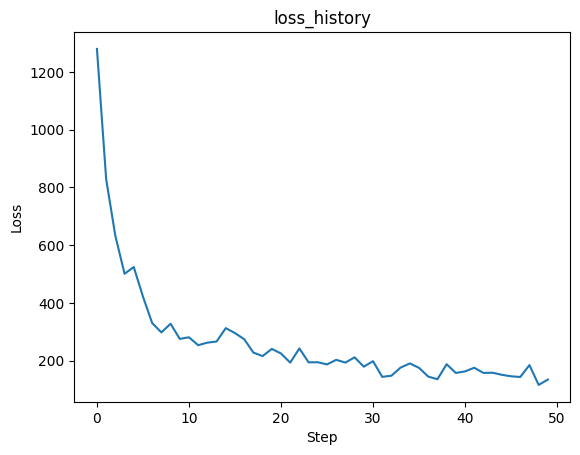

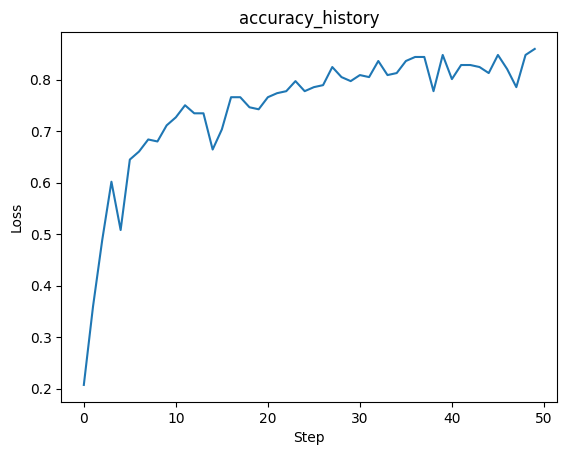

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.title('loss_history')
plt.plot(loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

# Виведіть графік точності
plt.title('accuracy_history')
plt.plot(accuracy_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [9]:
# Обчисліть точність навченої нейромережі
# Тестування моделі на тестових даних
pred = neural_net(x_test)
accuracy_test = accuracy(pred, y_test).numpy()
predictions = tf.argmax(pred, axis=1)

class_report = classification_report(y_test, predictions, target_names=[str(i) for i in range(num_classes)])
print("Точність на тестових даних:", accuracy_test)
print("Звіт класифікації:\n", class_report)

Точність на тестових даних: 0.8208
Звіт класифікації:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89       980
           1       0.96      0.96      0.96      1135
           2       0.82      0.78      0.80      1032
           3       0.75      0.84      0.79      1010
           4       0.82      0.74      0.78       982
           5       0.73      0.71      0.72       892
           6       0.88      0.87      0.88       958
           7       0.84      0.84      0.84      1028
           8       0.80      0.70      0.75       974
           9       0.71      0.83      0.76      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



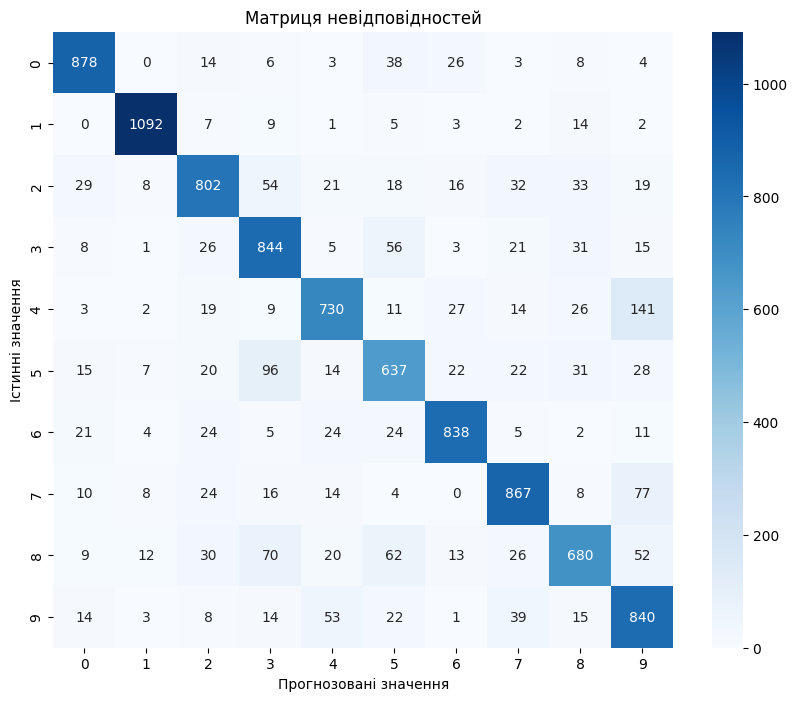

In [10]:
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця невідповідностей')
plt.xlabel('Прогнозовані значення')
plt.ylabel('Істинні значення')
plt.show()

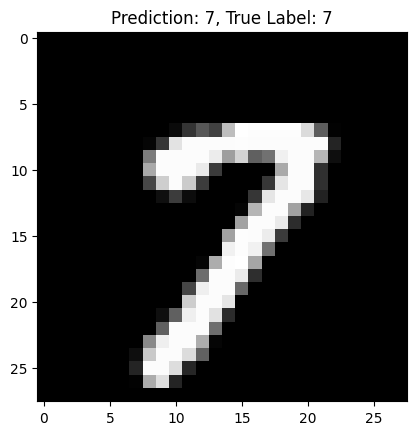

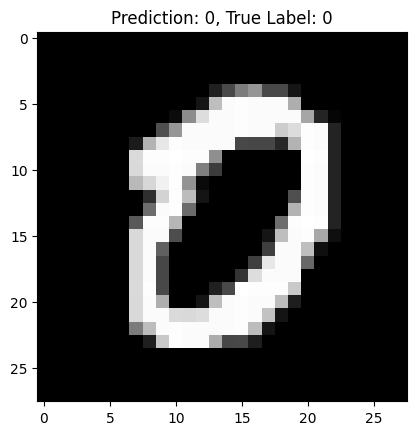

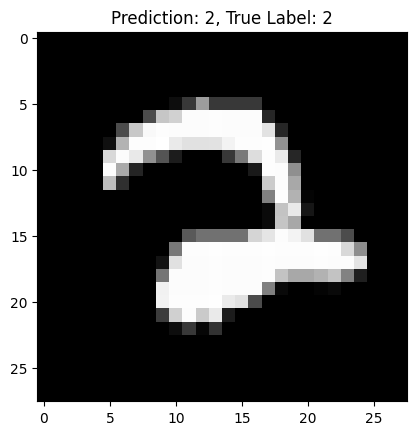

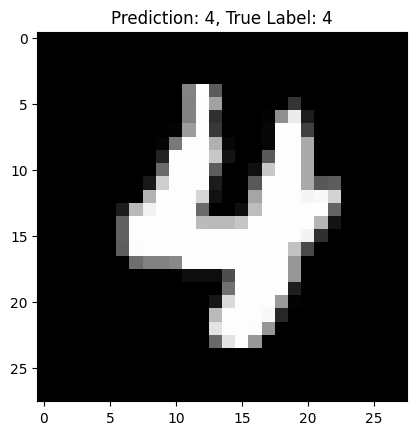

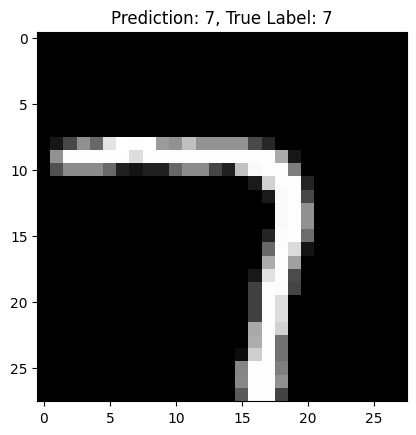

In [14]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

indices = np.random.choice(len(x_test), 5)
test_samples = x_test[indices]
test_labels = y_test[indices]

predictions = neural_net(test_samples)
predicted_labels = tf.argmax(predictions, axis=1)

for i in range(5):
    plt.imshow(test_samples[i].reshape(28, 28), cmap='gray')
    plt.title(f"Prediction: {predicted_labels[i].numpy()}, True Label: {test_labels[i]}")
    plt.show()

In [12]:
# В цілому нейромереажа навчена добре. В середньому вона класифікує правильно в 82% випадків.
# Оскільки точність на тестовому наборі збігається з точністю на тренувальному наборі, можна зробити висновок що модель не перенавчена
# Як показав звіт з класифікацї найгірше модель показала себе з передбачення "5" (з усіх п'ятірок модель виявила лише 71%)
# Та існують проблеми з передбачення "9" (лише 71% ідентифікованих моделью дев'яток, справді виявились дев'ятками)
# Також як показала Матриця невідповідностей через схожість рукописних цифер 141 четвірку модель ідентифікувала як дев'ять.
# І 96 п'ятірок модель ідентифікувала як трійки
# Як показало виведення зображень мітки виставленні вірно, а передбачення збігаються з мітками